# Offline heat budget over the broader location of the cruise. 
Use 2010 output to explore budget and debug offline calculations.

In [1]:
#Packages
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
import pandas as pd
from matplotlib.ticker import AutoMinorLocator

land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')
crs = ccrs.PlateCarree(central_longitude=-92.5)

In [26]:
# path = glob.glob('/d1/shared/TXLA_ROMS/nesting/2022/nest/ocean_dia_child_*.nc') #No tracer diagnostics, keep a copy for my records
tslice = slice('2010-06-10','2010-06-16')
path = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/nest/ver0/ocean_dia_child_0000*.nc') # We do have them for 2010
ds = xr.open_mfdataset(path, chunks = {'ocean_time':1})
ds = ds.sel(ocean_time=tslice)

# path1 = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/nest/ver0/ocean_avg_child_*.nc')
# path1 = glob.glob('/d1/shared/TXLA_ROMS/nesting/2022/nest/ocean_avg_child*.nc') 
path1 = glob.glob('/d1/shared/TXLA_ROMS/nesting/2022/nest/ocean_his_child*.nc') 
dsa = xroms.open_mfnetcdf(path1, chunks = {'ocean_time':1})
dsa, grida = xroms.roms_dataset(dsa, Vtransform = 2)
dsa = dsa.sel(ocean_time=tslice)

# model_time = str(datetime(2022,7,3,0,0))

# Dropping Reynolds averaging notation, the temperature equation $T$ may be written as 
#### $\frac{\partial T}{\partial t}+ \textbf{u} \cdot \nabla T =\nabla_H \cdot (\kappa_H \nabla_H T)+  \frac{\partial}{\partial z} \left(\kappa_T {\frac{\partial T}{\partial z}} \right)$.
with vertical boundary conditions 
#### $\kappa_T  \left(\frac{\partial T}{\partial z}\right)=\frac{Q_{net}}{\rho_0 C_p}$ @ $z=\eta$ ,
#### $\kappa_T  \left(\frac{\partial T}{\partial z}\right)=0$ @ $z=-h$.
After volume-integrating over a control volume extending from the ocean bottom to the sea surface, we have 
#### $\iiint \partial_t T \, dV + \iint (\mathbf{u}T) \cdot \hat{n} \, dA = \frac{Q_{net}}{\rho_0 C_p}$, 
where
<br>
#### $Q_{net}=Q_{sho}+Q_{lon}+Q_{sen}+Q_{lat}$

> Locally, the temperature buget terms have units of degrees C per second. 
> - $T$ is the temperature 
> - $\mathbf{u}$ is the 3D velocity vector
> - $\rho_0$ is the mean seawater density [kg/m$^3$].
> - $C_p$ is the specific heat of seawater [J/kg/deg C].
> - $\eta$ is the free surface
> - $h$ is the depth of the seafloor 
> - $Q_{net}$ is the surface net heat flux [W/m$^2$] with four components: 
> - $Q_{sho}$ is the shortwave flux [W/m$^2$]
> - $Q_{lon}$ is the longwave flux [W/m$^2$]
> - $Q_{sen}$ is the sensible heat flux [W/m$^2$]
> - $Q_{lat}$ is the latent heat flux [W/m$^2$]

# First, we construct a volume-integrated heat budget with diagnostic files, then do it offline 

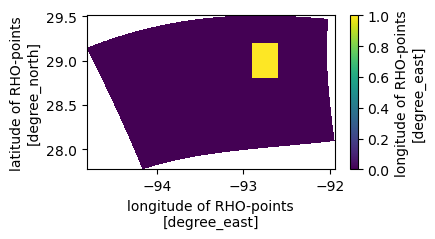

In [8]:
# Box for the location of the cruise
lon = np.array([-92.9,-92.6])
lat = np.array([28.8,29.2])
box = ((lon[0] < ds.lon_rho) & (ds.lon_rho < lon[1]) & (lat[0] < ds.lat_rho) & (ds.lat_rho < lat[1])).compute()

fig = plt.figure(figsize=(4,2))
box.plot(x='lon_rho',y='lat_rho')

In [64]:
dTdt = (ds.temp_rate*dsa.dV).where(box).sel(ocean_time=tslice).sum(['eta_rho','xi_rho','s_rho']).load()
hadv = (ds.temp_hadv*dsa.dV).where(box).sel(ocean_time=tslice).sum(['eta_rho','xi_rho','s_rho']).load()
vadv = (ds.temp_vadv*dsa.dV).where(box).sel(ocean_time=tslice).sum(['eta_rho','xi_rho','s_rho']).load()
T_adv = hadv+vadv
hdiff = (ds.temp_hdiff*dsa.dV).where(box).sel(ocean_time=tslice).sum(['eta_rho','xi_rho','s_rho']).load()
vdiff = (ds.temp_vdiff*dsa.dV).where(box).sel(ocean_time=tslice).sum(['eta_rho','xi_rho','s_rho']).load()
diffusion = hdiff+vdiff

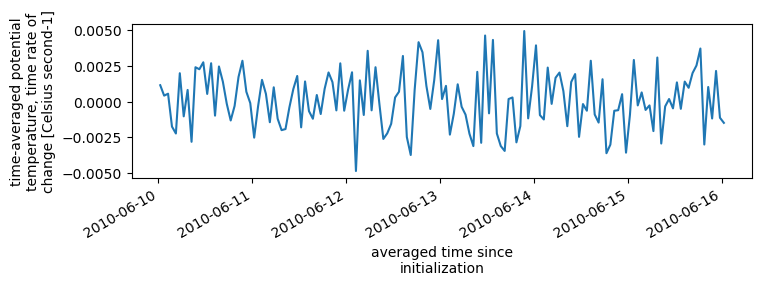

In [65]:
res = (dTdt-T_adv)-diffusion
res.plot(figsize=(8,2))

# The residual is nill, good to go 

In [73]:
dTdt.name = 'dTdt'
hadv.name = 'hadv'
vadv.name = 'vadv'
T_adv.name = 'T_adv'
hdiff.name = 'hdiff'
vdiff.name = 'vdiff'
diffusion.name = 'diffusion'
ds_test = xr.merge([dTdt,hadv,vadv,T_adv,hdiff,vdiff,diffusion])
ds_test.to_netcdf('heat_budget_june_2010.nc')

In [5]:
ds_test = xr.open_dataset('heat_budget_june_2010.nc')

## Plot the results 

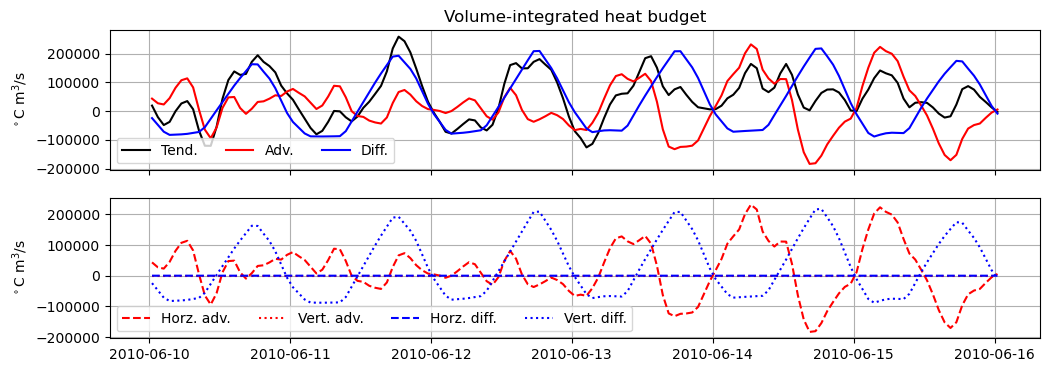

In [6]:
fig, ax = plt.subplots(2,1, figsize = (12,4))

ax[0].plot(ds_test.dTdt.ocean_time, ds_test.dTdt, label = 'Tend.', lw = 1.5, c = 'k')
ax[0].plot(ds_test.dTdt.ocean_time, ds_test.T_adv, label = 'Adv.', lw = 1.5, c = 'r')
ax[0].plot(ds_test.dTdt.ocean_time, ds_test.diffusion, label = 'Diff.', lw = 1.5, c = 'b')
ax[0].set_xticklabels('')
ax[0].set_title('Volume-integrated heat budget')
ax[1].plot(ds_test.dTdt.ocean_time, ds_test.hadv, label = 'Horz. adv.', lw = 1.5, c = 'r', ls = '--')
ax[1].plot(ds_test.dTdt.ocean_time, ds_test.vadv, label = 'Vert. adv.', lw = 1.5, c = 'r', ls = ':')
ax[1].plot(ds_test.dTdt.ocean_time, ds_test.hdiff, label = 'Horz. diff.', lw = 1.5, c = 'b', ls = '--')
ax[1].plot(ds_test.dTdt.ocean_time, ds_test.vdiff, label = 'Vert. diff.', lw = 1.5, c = 'b', ls = ':')

for i in range(2):
    ax[i].grid(which='both')
    ax[i].legend(loc='best', ncol = 4)
    ax[i].set_ylabel(r'$^\circ$C m$^3$/s')
    
# plt.savefig('vint_heat_budget_june_2010_child.jpg', dpi=300)

In [8]:
print('Bulk horz/total adv [%]', ds_test.hadv.sum().values/(ds_test.T_adv.sum().values)*100)
print('Bulk horz/total diff [%]', ds_test.hdiff.sum().values/(ds_test.diffusion.sum().values)*100)

Bulk horz/total adv [%] 100.00000036341056
Bulk horz/total diff [%] 0.043738213541609644


The budget is balanced as expected. While tendency peaks in magnitude, there is a clear diurnal heating component that drives the vertical boundary condition at the sea surface. Lateral difffusion is negligble, so is vertical advection

# Construct the volume-averaged heat budget 

In [78]:
V = dsa.dV.where(box).sel(ocean_time=tslice).sum(['eta_rho','xi_rho','s_rho']).load()

dTdt_vavg = dTdt/V
hadv_vavg = hadv/V
vadv_vavg = vadv/V
T_adv_vavg = T_adv/V
hdiff_vavg = hdiff/V
vdiff_vavg = vdiff/V
diffusion_vavg = diffusion/V

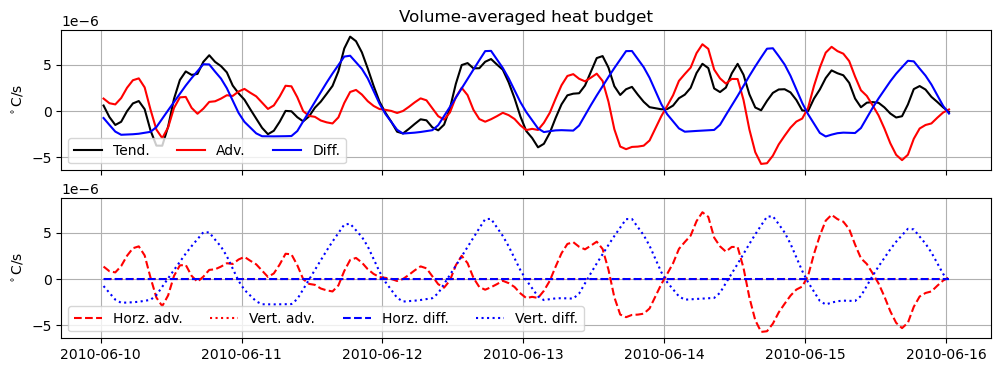

In [87]:
fig, ax = plt.subplots(2,1, figsize = (12,4), sharey=True)

ax[0].plot(dTdt.ocean_time, dTdt_vavg, label = 'Tend.', lw = 1.5, c = 'k')
ax[0].plot(dTdt.ocean_time, T_adv_vavg, label = 'Adv.', lw = 1.5, c = 'r')
ax[0].plot(dTdt.ocean_time, diffusion_vavg, label = 'Diff.', lw = 1.5, c = 'b')
ax[0].set_xticklabels('')
ax[0].set_title('Volume-averaged heat budget')
ax[1].plot(dTdt.ocean_time, hadv_vavg, label = 'Horz. adv.', lw = 1.5, c = 'r', ls = '--')
ax[1].plot(dTdt.ocean_time, vadv_vavg, label = 'Vert. adv.', lw = 1.5, c = 'r', ls = ':')
ax[1].plot(dTdt.ocean_time, hdiff_vavg, label = 'Horz. diff.', lw = 1.5, c = 'b', ls = '--')
ax[1].plot(dTdt.ocean_time, vdiff_vavg, label = 'Vert. diff.', lw = 1.5, c = 'b', ls = ':')

for i in range(2):
    ax[i].grid(which='both')
    ax[i].legend(loc='best', ncol = 4)
    ax[i].set_ylabel(r'$^\circ$C/s')

### Now repeat, but vertically average over the top 1 m to the sea surface 

In [24]:
dTdt = ((ds.temp_rate).where((dsa.z_rho)>-1).where(box)).sel(ocean_time=tslice).mean(['eta_rho','xi_rho','s_rho']).load()
hadv = ((ds.temp_hadv).where(dsa.z_rho>-1).where(box)).sel(ocean_time=tslice).mean(['eta_rho','xi_rho','s_rho']).load()
vadv = ((ds.temp_vadv).where(dsa.z_rho>-1).where(box)).sel(ocean_time=tslice).mean(['eta_rho','xi_rho','s_rho']).load()
T_adv = hadv+vadv
hdiff = ((ds.temp_hdiff).where(dsa.z_rho>-1).where(box)).sel(ocean_time=tslice).mean(['eta_rho','xi_rho','s_rho']).load()
vdiff = ((ds.temp_vdiff).where(dsa.z_rho>-1).where(box)).sel(ocean_time=tslice).mean(['eta_rho','xi_rho','s_rho']).load()
diffusion = hdiff+vdiff
         
dTdt.name = 'dTdt'
hadv.name = 'hadv'
vadv.name = 'vadv'
T_adv.name = 'T_adv'
hdiff.name = 'hdiff'
vdiff.name = 'vdiff'
diffusion.name = 'diffusion'
ds_test = xr.merge([dTdt,hadv,vadv,T_adv,hdiff,vdiff,diffusion])
ds_test.to_netcdf('heat_budget_june_2010_top1m_avg.nc')

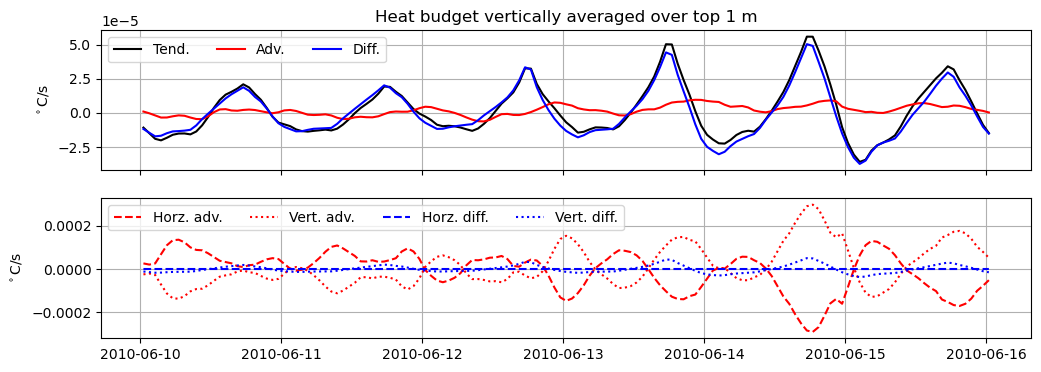

In [9]:
ds_test = xr.open_dataset('heat_budget_june_2010_top1m_avg.nc')

fig, ax = plt.subplots(2,1, figsize = (12,4))
ax[0].plot(ds_test.dTdt.ocean_time, ds_test.dTdt, label = 'Tend.', lw = 1.5, c = 'k')
ax[0].plot(ds_test.dTdt.ocean_time, ds_test.T_adv, label = 'Adv.', lw = 1.5, c = 'r')
ax[0].plot(ds_test.dTdt.ocean_time, ds_test.diffusion, label = 'Diff.', lw = 1.5, c = 'b')
ax[0].set_xticklabels('')
ax[0].set_title('Heat budget vertically averaged over top 1 m')
ax[1].plot(ds_test.dTdt.ocean_time, ds_test.hadv, label = 'Horz. adv.', lw = 1.5, c = 'r', ls = '--')
ax[1].plot(ds_test.dTdt.ocean_time, ds_test.vadv, label = 'Vert. adv.', lw = 1.5, c = 'r', ls = ':')
ax[1].plot(ds_test.dTdt.ocean_time, ds_test.hdiff, label = 'Horz. diff.', lw = 1.5, c = 'b', ls = '--')
ax[1].plot(ds_test.dTdt.ocean_time, ds_test.vdiff, label = 'Vert. diff.', lw = 1.5, c = 'b', ls = ':')

for i in range(2):
    ax[i].grid(which='both')
    ax[i].legend(loc='best', ncol = 4)
    ax[i].set_ylabel(r'$^\circ$C/s')

# To conclude, we can do the calculations efficiently for a control volume of this size, but lack the means to do it offline. Directly check the calculation error of the individual terms

In [55]:
paths = ['/d1/shared/TXLA_ROMS/numerical_mixing/nest/ver0/ocean_his_child_*.nc', 
         '/d1/shared/TXLA_ROMS/numerical_mixing/nest/ver0/ocean_avg_child_*.nc']

tslice = slice('2010-06-10','2010-06-12')
             
def open_roms(path):
    ds1 = xroms.open_mfnetcdf(glob.glob(path))
    ds1, grid1 = xroms.roms_dataset(ds1)
    ds1 = ds1.sel(ocean_time=tslice)
    return ds1, grid1

dsa = []
grida = []
for i in range(len(paths)):
    ds1, grid1 = open_roms(paths[i])
    dsa.append(ds1)
    grida.append(grid1)

In [56]:
vdiff_on = (ds.temp_vdiff*dsa[1].dV).where(box).sel(ocean_time=tslice).sum(['eta_rho','xi_rho','s_rho']).load()
vdiff_of = ((dsa[0].shflux/(1025*3850))*dsa[0].dA).where(box).sel(ocean_time=tslice).sum(['eta_rho','xi_rho']).load()

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


Text(0.5, 1.0, 'Volume integrated diffusive heat flux')

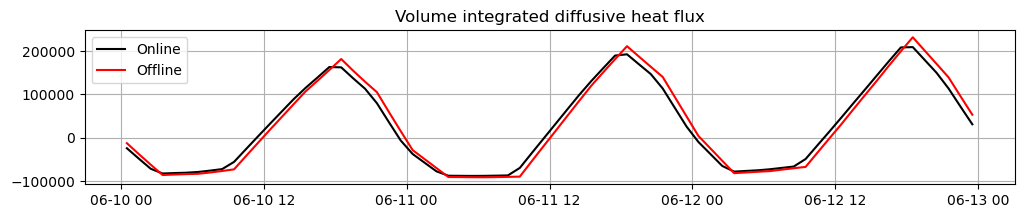

In [15]:
fig, ax = plt.subplots(1,1, figsize = (12,2))

ax.plot(vdiff_on.ocean_time, vdiff_on, label = 'Online', lw = 1.5, c = 'k')
ax.plot(vdiff_on.ocean_time, vdiff_of, label = 'Offline', lw = 1.5, c = 'r')
ax.legend()
ax.grid()
ax.set_title('Volume-integrated diffusive heat flux')

# Tendency term next, not expecting high accuracy. 
Compute it as the total change of temperature in a cell, see Schlichting et al. 2023

In [18]:
dTdt_on = (ds.temp_rate*dsa[1].dV).where(box).sel(ocean_time=tslice).sum(['eta_rho','xi_rho','s_rho']).load()

temp = dsa[1].temp.where(box).sel(ocean_time=tslice).values
delta = dsa[1].dV.where(box).sel(ocean_time=tslice).values

tempv = temp*delta
dtempvdt = (((tempv).values[2:] - (tempv).values[:-2])/(2*3600))
dtempvdt_v =  dtempvdt/(delta.values[1:-1])
dTdt_of = (dtempvdt_v*delta[1:-1]).sum(axis = (1,2,3))

Text(0.5, 1.0, 'Volume-integrated tendency term')

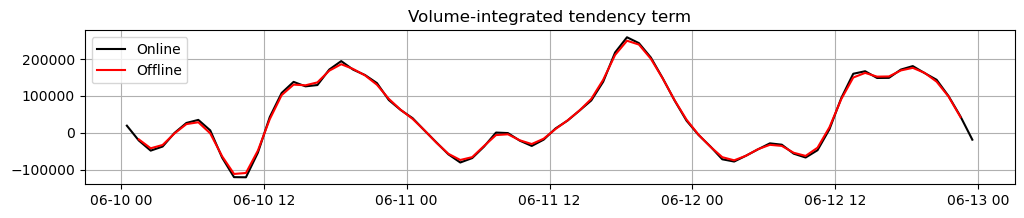

In [27]:
fig, ax = plt.subplots(1,1, figsize = (12,2))

ax.plot(vdiff_on.ocean_time, dTdt_on, label = 'Online', lw = 1.5, c = 'k')
ax.plot(vdiff_on.ocean_time[1:-1], dTdt_of, label = 'Offline', lw = 1.5, c = 'r')
ax.legend()
ax.grid()
ax.set_title('Volume-integrated tendency term')

# Advection term next 

In [9]:
hadv = (ds.temp_hadv*dsa[1].dV).where(box).sel(ocean_time=tslice).sum(['eta_rho','xi_rho','s_rho']).load()
vadv = (ds.temp_vadv*dsa[1].dV).where(box).sel(ocean_time=tslice).sum(['eta_rho','xi_rho','s_rho']).load()
T_adv = hadv+vadv

In [10]:
boxloc = dsa[0].temp.where(box,drop=True)
xislice = slice(boxloc.xi_rho[0].values, boxloc.xi_rho[-1].values)
etaslice = slice(boxloc.eta_rho[0].values, boxloc.eta_rho[-1].values)
print(xislice,etaslice)

slice(array(423), array(512), None) slice(array(273), array(460), None)


/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [95]:
#Start of functions needed for advection
def volume_flux(ds1,grid,box,tslice,etaslice,xislice):
    '''
Computes the volume advection through the lateral boundaries of a control volume for ROMS model output using
average or history files. 
-----
Input: 
ds - xarray roms dataset
grid - xgcm grid of roms output
xislice - slice object of desired xi points
etaslice -slice object of desired eta points
-----
Output:
Qds: Xarray dataset of volume flux at the four horizontal control surfaces
vol_adv: Xarray dataarray of the net volume flux as a function of time only
    '''
    #-1 on the starting slices for u and v points to align the grid
    #Look at classical picture of ROMS C-grid to reason this out
    
    urho = grid.interp(ds1.u,'X', boundary = 'extend')
    vrho = grid.interp(ds1.v,'Y', boundary = 'extend')
    
    Huon = (urho*ds1.dy*ds1.dz).where(box).sel(ocean_time=tslice)
    Hvom = (vrho*ds1.dx*ds1.dz).where(box).sel(ocean_time=tslice)
    
    uflux = Huon.isel(eta_rho = etaslice, xi_rho = xislice)
    vflux = Hvom.isel(eta_rho = etaslice, xi_rho = xislice)

    QW = uflux.isel(xi_rho = 0) #West
    QE = uflux.isel(xi_rho = -1) #East
    QN = vflux.isel(eta_rho = -1) #North
    QS = vflux.isel(eta_rho = 0) #South

    #Name individual components in case histograms are made, which require the variables be named
    QW.name = 'QW'
    QE.name = 'QE'
    QN.name = 'QN'
    QS.name = 'QS'

    Qds = xr.merge([QW, QE, QN, QS], compat='override')
    
    #Note the negative sign here is placed so fluxes out of the control volume
    #are considered positive
    vol_adv = -(Qds.QW.sum(['eta_rho', 's_rho'])-Qds.QE.sum(['eta_rho', 's_rho']) \
                 +Qds.QS.sum(['xi_rho', 's_rho'])-Qds.QN.sum(['xi_rho', 's_rho']))
        
    return Qds, vol_adv

def temp_cv(ds1,box,tslice, grid,etaslice, xislice):
    '''
Computes the boundary potential temperature of a control volume for ROMS model output. 
-----
Input: 
ds - xarray roms dataset
grid - xgcm grid of roms output
xislice - slice object of desired xi points
etaslice -slice object of desired eta points
-----
Output:
tempds: xarray dataset of temp at the four horizontal control surfaces. 
    '''    
    t = ds1.temp.where(box).sel(ocean_time=tslice)
    
    tW = t.isel(eta_rho = etaslice, xi_rho = xislice).isel(xi_rho = 0) #West
    tE = t.isel(eta_rho = etaslice, xi_rho = xislice).isel(xi_rho = -1) #East
    tN = t.isel(eta_rho = etaslice, xi_rho = xislice).isel(eta_rho = -1) #North
    tS = t.isel(eta_rho = etaslice, xi_rho = xislice).isel(eta_rho = 0) #South
   
    #DataArray Metadata
    tW.name = 'tW'
    tE.name = 'tE'
    tN.name = 'tN'
    tS.name = 'tS'
    
    tempds = xr.merge([tW, tE, tN, tS], compat='override')
    return tempds

def temp_flux(tempds, Qds):
    '''
Computes the boundary temperature transport of a control volume for ROMS model output. 
-----
Input: 
tempds - Xarray dataset of the temp at the boundaries
Qds - Xarray dataset of the voume flux at the boundaries
-----
Output:
Qsds: Xarray dataset of salinity transport at the four horizontal control surfaces. 
-----
    '''
    #Temp flux
    QtW = tempds.tW*Qds.QW
    QtE = tempds.tE*Qds.QE
    QtN = tempds.tN*Qds.QN
    QtS = tempds.tS*Qds.QS
    
    QtW.name = 'QtW'
    QtE.name = 'QtE'
    QtN.name = 'QtN'
    QtS.name = 'QtS'
    
    Qtds = xr.merge([QtW, QtE, QtN, QtS], compat='override')
    
    return Qtds

In [98]:
etaslice = slice(273,460)
xislice = slice(423,512)

# Temp for the four control surfaces 
tempds = temp_cv(dsa[1],box,tslice,grida[1],etaslice,xislice)
tempds = tempds.load()
# Volume fluxes for the four control surfaces 
Qds, vol_adv = volume_flux(dsa[1], grida[1],box, tslice, xislice, etaslice)
# Temp advection that is volume integrated
Qtds= temp_flux(tempds, Qds)
temp_xr = -(Qtds.QtW.sum(['eta_rho', 's_rho'])-Qtds.QtE.sum(['eta_rho', 's_rho']) \
             +Qtds.QtS.sum(['xi_rho', 's_rho'])-Qtds.QtN.sum(['xi_rho', 's_rho'])).load()

Text(0.5, 1.0, 'Area-integrated temperature advection term')

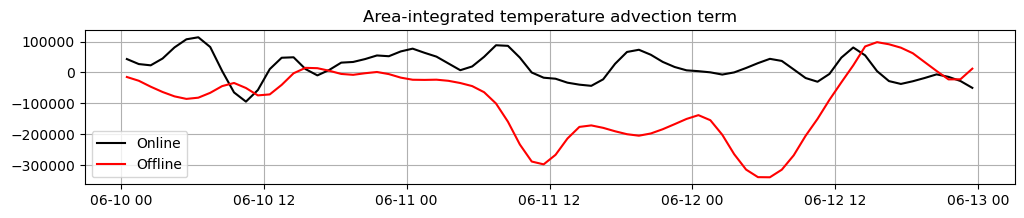

In [99]:
fig, ax = plt.subplots(1,1, figsize = (12,2))

ax.plot(T_adv.ocean_time, T_adv, label = 'Online', lw = 1.5, c = 'k')
ax.plot(T_adv.ocean_time, temp_xr, label = 'Offline', lw = 1.5, c = 'r')
ax.legend()
ax.grid()
ax.set_title('Area-integrated temperature advection term')

# Advection isn't even close, not sure why it's so off. Trends aren't even right. Try doing it another way with different interpolation

In [23]:
dydzt = grida[0].interp((dsa[0].dy*dsa[0].dz*dsa[0].temp).where(box), 'X')
dxdzt = grida[0].interp((dsa[0].dx*dsa[0].dz*dsa[0].temp).where(box), 'Y')
utflux = (dydzt*dsa[0].u).sel(ocean_time=tslice)
vtflux = (dxdzt*dsa[0].v).sel(ocean_time=tslice)

uflux = utflux.isel(eta_rho = etaslice, xi_u = slice(xislice.start-1, xislice.stop))
vflux = vtflux.isel(eta_v = slice(etaslice.start-1, etaslice.stop), xi_rho = xislice)

QtW = uflux.isel(xi_u = 0) #West
QtE = uflux.isel(xi_u = -1) #East
QtN = vflux.isel(eta_v = -1) #North
QtS = vflux.isel(eta_v = 0) #South

#Name individual components in case histograms are made, which require the variables be named
QtW.name = 'QW'
QtE.name = 'QE'
QtN.name = 'QN'
QtS.name = 'QS'

Qtds = xr.merge([QtW, QtE, QtN, QtS], compat='override')

tadv_of = (-(Qtds.QW.sum(['eta_rho', 's_rho'])-Qtds.QE.sum(['eta_rho', 's_rho']) \
                 +Qtds.QS.sum(['xi_rho', 's_rho'])-Qtds.QN.sum(['xi_rho', 's_rho']))).load()

Text(0.5, 1.0, 'Area-integrated temperature advection term')

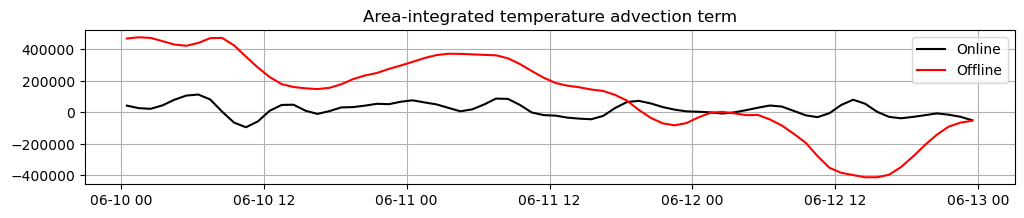

In [24]:
fig, ax = plt.subplots(1,1, figsize = (12,2))

ax.plot(T_adv.ocean_time, T_adv, label = 'Online', lw = 1.5, c = 'k')
ax.plot(T_adv.ocean_time, tadv_of, label = 'Offline', lw = 1.5, c = 'r')
ax.legend()
ax.grid()
ax.set_title('Area-integrated temperature advection term')

# Still way off... not good

# Look at the components of the surface net heat flux for the student cruise. 

In [34]:
tslice = slice('2022-07-02','2022-07-05')
path1 = glob.glob('/d1/shared/TXLA_ROMS/nesting/2022/nest/ocean_his_child*.nc') 
dsa = xroms.open_mfnetcdf(path1, chunks = {'ocean_time':1})
dsa, grida = xroms.roms_dataset(dsa, Vtransform = 2)
dsa = dsa.sel(ocean_time=tslice)

In [41]:
lon = np.array([-92.6,-92])
lat = np.array([28.8,29.2])
box = ((lon[0] < dsa.lon_rho) & (dsa.lon_rho < lon[1]) & (lat[0] < dsa.lat_rho) & (dsa.lat_rho < lat[1])).compute()

In [47]:
ql = dsa.latent.where(box).sel(ocean_time=tslice).mean(['xi_rho','eta_rho']).load()
qsw = dsa.swrad.where(box).sel(ocean_time=tslice).mean(['xi_rho','eta_rho']).load()
qsen = dsa.sensible.where(box).sel(ocean_time=tslice).mean(['xi_rho','eta_rho']).load()
qlw = dsa.lwrad.where(box).sel(ocean_time=tslice).mean(['xi_rho','eta_rho']).load()
qnet = dsa.shflux.where(box).sel(ocean_time=tslice).mean(['xi_rho','eta_rho']).load()

Text(0, 0.5, 'W/m$^2$')

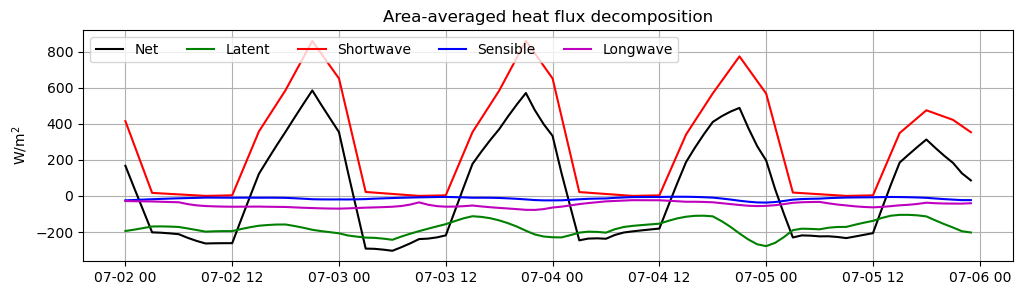

In [53]:
fig, ax = plt.subplots(1,1, figsize = (12,3))

ax.plot(ql.ocean_time, qnet, label = 'Net', lw = 1.5, c = 'k')
ax.plot(ql.ocean_time, ql, label = 'Latent', lw = 1.5, c = 'g')
ax.plot(ql.ocean_time, qsw, label = 'Shortwave', lw = 1.5, c = 'r')
ax.plot(ql.ocean_time, qsen, label = 'Sensible', lw = 1.5, c = 'b')
ax.plot(ql.ocean_time, qlw, label = 'Longwave', lw = 1.5, c = 'm')

ax.legend(ncol = 5, loc = 'upper left')
ax.grid()
ax.set_title('Area-averaged heat flux decomposition')
ax.set_ylabel('W/m$^2$')

# Looks good 